### Meta Labeling

금융에서 흔히 볼 수 있는 것은 특정 증권을 매수 또는 매도하고 싶은지는 알 수 있지만, 어느 정도 베팅해야 할지 확신이 덜 선다는 것이다. 포지션의 방향을 결정하는 모델은 그 포지션의 크기를 결정하는 최선의 모델이 아닐 수 있다. 아마도 그 크기는 모델의 최근 성과의 함수가 돼야 하는 반면, 최근 성과는 포지션의 방향을 예측하는 것과 무관하다.

좋은 베팅 크기 결정 모델을 갖는 것은 매우 종요하다. 60%의 정밀도와 90%의 재현율을 가진 투자 전략을 고려하자. 90%의 재현율은 100개의 진정한 투자 기회 중 90개를 예측하는 전략이다. 60%의 정밀도는 100개의 예측 기회 중 60개가 사실이라는 것을 의미한다. 이러한 전략은 만약 60개의 참 양성에 대한 베팅 크기가 작다면, 그리고 40개의 거짓 양성에 대한 베팅 크기가 크다면 돈을 잃을 것이다. 투자자로서 가격에 대해서는 (합법적인) 통제를 할 수 없으며, 투자자로서 할 수 있고 반드시 해야 할 중요한 결정은 베팅의 크기를 적절하게 정하는 것이다.

Meta labeling은 투자자가 false positive에 노출되는 것을 피하거나 false positive를 최소한 줄이는 데 유용하다. Meta Labeling은 더 높은 정밀도를 얻는 대가로 약간의 재현율을 포기함으로써 이를 달성한다. 위의 예에서 Meta Labeling 레이러를 추가하면 재현율 70%와 정밀도 70%가 발생할 수 있으므로 모델의 F1 score가 개산된다.

Meta Labeling의 목적은 손실이 '0'으로 labeling되고 이익이 '1'로 Labeling되는 primary model의 예측 결과에 대해 secondary model을 훈련시키는 것이다. 따라서, secondary model은 방향을 예측하지 않는다. 대신 secondary model은 primary model이 특정 예측에서 성공할지 실패할지를 예측한다. 그러고 나서 '1' 예측과 관련된 확률을 사용해 다음에 설명하는 바와 같이 포지션의 크기를 조정할 수 있다.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from FinancialMachineLearning.labeling.labeling import *

triple_barrier_event = pd.read_parquet('../../../Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('../../../Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('../../../Data/AAPL_feature_matrix.parquet')

labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)
triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

In [6]:
feature_matrix['side'] = triple_barrier_event['side'].copy()
feature_matrix['label'] = meta_labels['bin'].copy()
feature_matrix.drop(['Open','High','Low','Close','Adj Close','Volume'], axis = 1, inplace = True)
feature_matrix.dropna(inplace = True)
matrix = feature_matrix[feature_matrix['side'] != 0]

X = matrix.drop(['side','label'], axis = 1)
y = matrix['label']

X_train, X_test = X.loc[:'2019'], X.loc['2020':]
y_train, y_test = y.loc[:'2019'], y.loc['2020':]

samples_info_sets = triple_barrier_event.loc[X_train.index].loc[:'2019', 't1']

In [7]:
from sklearn.ensemble import RandomForestClassifier
from FinancialMachineLearning.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            triple_barrier_event.index.to_series(),
            triple_barrier_event['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [8]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

y_prob = forest_fit.predict_proba(X_test)[:, 1]
y_pred = forest_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 86.55%


#### 1. Bet Sizing by Expected Sharpe Ratio

$p$는 투자 기회가 이익 $\pi$를 산출할 것으로 예상되는 확률이고, $1 - p$는 투자 기회가 어떤 크기 $\pi > 0$의 대칭적 보상으로 이익 $-\pi$를 산출하리라는 기대 확률이다. 투자 기회로부터의 기대 이익은 $\mu = p\pi + (1-p)(-\pi) = \pi(2p-1)$이다. 투자 기회로부터의 기대 분산은 $\sigma^2 = 4\pi^2p(1-p)$이다. 투자 기회에 관련된 sharpe ratio는 다음과 같이 추정할 수 있다.

$$z = \frac{\mu}{\sigma} = \frac{p-\frac{1}{2}}{\sqrt{p(1-p)}}$$

여기서 $z \in (-\infty, +\infty)$이다. 투자 기회의 sharpe ratio가 표준 가우시안 분포를 따른다고 가정할 때 우리는 베팅 크기를 $m = 2Z[z] - 1$로 도출할 수 있다. 여기서 $Z[.]$는 표준 가우시안 분포의 누적 분포 함수로서 $m \in [-1, 1]$은 균등 분포를 따른다.

In [18]:
from FinancialMachineLearning.bet_sizing.bet_sizing import get_gaussian_betsize

signals = get_gaussian_betsize(y_prob)

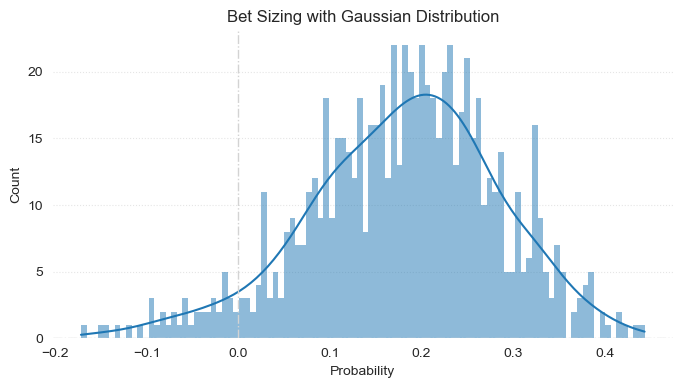

In [19]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(signals, bins = 100, kde = True, edgecolor = 'none', ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.axhline(y = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.title('Bet Sizing with Gaussian Distribution')
plt.xlabel('Probability')
plt.show()

#### 2. Ensemble Bet Sizing

투자 기회가 수익성이 있는지 여부에 대한 이진 예측을 하는 $n$개의 Meta labeling 분류기, 즉 $y_i = \{0,1\}, i=1,\dots, n$을 고려하자. 수익성이 있는 참 확률은 $p$이고, 예측 $y_i$는 bernoulli 분포에서 추출된다. 즉 $\sum_{i=1}^n y_i \sim B[n,p]$이며, 여기서 $B[n,p]$는 확률 $p$로 $n$번 시행하는 이항 분포이다. 예측이 독립적이고 동일하게 분포된다고 가정하면 de Moivrre-Laplace 정리에 따라 $\sum_{i=1}^n y_i$의 분포는 $n$이 무한대로 커짐에 따라 평균 $np$와 분산 $np(1-p)$를 가진 가우시안 분포로 수렴한다. 따라서 $\lim_{n \rightarrow \infty} \frac{1}{n}\sum_{i=1}^n y_i \sim N\left[p,\frac{p(1-p)}{n}\right]$이며, 이는 Lindeberg-Levy theorem의 특수한 경우이다.

$\hat{p}$를 $n$의 Meta Labeling 분류기의 평균 예측이라고 하자. 즉 $\hat{p} = \frac{1}{n} \sum_{i=1}^n y_i, \hat{y}$와 관련된 표준 편차는 $\sqrt{\hat{p}(1 - \hat{p}) / n}$이다. 귀무가설 $H_0 : p = \frac{1}{2}$에 따라 통계량 $t = \frac{(\hat{p} - \frac{1}{2})}{\sqrt{\hat{p}(1 - \hat{p})}} \sqrt{n}, t \in \left( -\infty, +\infty\right)$는 $n-1$ 자유도를 가진 t-student 분포를 따른다. 베팅 크기를 $m = 2 t_{n-1}[t] - 1$로 도출할 수 있다. 여기서 $t_{n-1}[.]$는 $n-1$ 자유도를 가진 t-student 누적 분포 함수이고, $m \in [-1, 1]$은 균등 분포를 따른다.

In [20]:
from FinancialMachineLearning.bet_sizing.bet_sizing import get_tstats_betsize

signals = get_tstats_betsize(y_prob, N = 10)

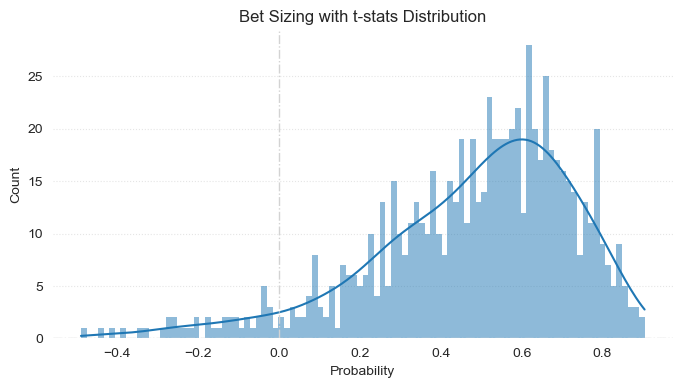

In [21]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(signals, bins = 100, kde = True, edgecolor = 'none', ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.axhline(y = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.title('Bet Sizing with t-stats Distribution')
plt.xlabel('Probability')
plt.show()